In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_DenseNet169"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


input_tensor = Input(shape = input_shape)  
model = DenseNet169(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
# bottleneck_final_model.summary()

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 2s - loss: 0.4705 - acc: 0.7761 - val_loss: 0.2898 - val_acc: 0.9010
Epoch 2/1000
 - 1s - loss: 0.2673 - acc: 0.8961 - val_loss: 0.1935 - val_acc: 0.9368
Epoch 3/1000
 - 1s - loss: 0.1799 - acc: 0.9381 - val_loss: 0.1424 - val_acc: 0.9603
Epoch 4/1000
 - 1s - loss: 0.1349 - acc: 0.9546 - val_loss: 0.1130 - val_acc: 0.9666
Epoch 5/1000
 - 1s - loss: 0.1029 - acc: 0.9695 - val_loss: 0.0894 - val_acc: 0.9761
Epoch 6/1000
 - 1s - loss: 0.0817 - acc: 0.9760 - val_loss: 0.0872 - val_acc: 0.9709
Epoch 7/1000
 - 1s - loss: 0.0659 - acc: 0.9814 - val_loss: 0.0627 - val_acc: 0.9824
Epoch 8/1000
 - 1s - loss: 0.0506 - acc: 0.9875 - val_loss: 0.0535 - val_acc: 0.9842
Epoch 9/1000
 - 1s - loss: 0.0432 - acc: 0.9886 - val_loss: 0.0451 - val_acc: 0.9870
Epoch 10/1000
 - 1s - loss: 0.0361 - acc: 0.9915 - val_loss: 0.0375 - val_acc: 0.9916
Epoch 11/1000
 - 1s - loss: 0.0310 - acc: 0.9927 - val_loss: 0.0329 - val_acc: 0.9926
Epoch 12/1000
 

Epoch 94/1000
 - 1s - loss: 4.8978e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9979
Epoch 95/1000
 - 1s - loss: 2.7574e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9972
Epoch 96/1000
 - 1s - loss: 1.2276e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9975
Epoch 97/1000
 - 1s - loss: 8.5899e-06 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9972
Epoch 98/1000
 - 1s - loss: 6.2447e-05 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9975
Epoch 99/1000
 - 1s - loss: 1.6718e-05 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 0.9968
Epoch 100/1000
 - 1s - loss: 1.0304e-05 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 0.9975
Epoch 101/1000
 - 1s - loss: 9.1420e-05 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9979
Epoch 102/1000
 - 1s - loss: 2.6415e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9975
Epoch 103/1000
 - 1s - loss: 4.7003e-05 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 0.9975
Epoch 104/1000
 - 1s - loss: 1.4677e-05 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9965
Epoch

 - 1s - loss: 4.2689e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9979
Epoch 185/1000
 - 1s - loss: 2.1632e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9975
Epoch 186/1000
 - 1s - loss: 3.0506e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9979
Epoch 187/1000
 - 1s - loss: 5.8381e-07 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9972
Epoch 188/1000
 - 1s - loss: 2.3804e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9972
Epoch 189/1000
 - 1s - loss: 5.7814e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9972
Epoch 190/1000
 - 1s - loss: 5.1435e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9975
Epoch 191/1000
 - 1s - loss: 3.7515e-07 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9979
Epoch 192/1000
 - 1s - loss: 4.0333e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9975
Epoch 193/1000
 - 1s - loss: 3.1698e-07 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9968
Epoch 194/1000
 - 1s - loss: 3.1161e-07 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9979
Epoch 195/1000

Epoch 275/1000
 - 1s - loss: 3.3143e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9975
Epoch 276/1000
 - 1s - loss: 4.5267e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 277/1000
 - 1s - loss: 1.4411e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9975
Epoch 278/1000
 - 1s - loss: 1.8193e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9975
Epoch 279/1000
 - 1s - loss: 1.7004e-07 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9972
Epoch 280/1000
 - 1s - loss: 2.0518e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9979
Epoch 281/1000
 - 1s - loss: 2.6043e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9979
Epoch 282/1000
 - 1s - loss: 1.2301e-06 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 0.9979
Epoch 283/1000
 - 1s - loss: 1.5123e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9975
Epoch 284/1000
 - 1s - loss: 1.7938e-06 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9982
Epoch 285/1000
 - 1s - loss: 1.7253e-07 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 0.9982

 - 1s - loss: 1.4335e-07 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9979
Epoch 366/1000
 - 1s - loss: 1.3164e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 367/1000
 - 1s - loss: 1.2423e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9982
Epoch 368/1000
 - 1s - loss: 1.3677e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 369/1000
 - 1s - loss: 1.3657e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9979
Epoch 370/1000
 - 1s - loss: 1.2549e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9979
Epoch 371/1000
 - 1s - loss: 1.2406e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9979
Epoch 372/1000
 - 1s - loss: 1.3228e-07 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9979
Epoch 373/1000
 - 1s - loss: 1.3722e-07 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9979
Epoch 374/1000
 - 1s - loss: 1.2907e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9979
Epoch 375/1000
 - 1s - loss: 1.2417e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 376/1000

Epoch 456/1000
 - 1s - loss: 1.3452e-07 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9979
Epoch 457/1000
 - 1s - loss: 1.2336e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9982
Epoch 458/1000
 - 1s - loss: 1.3599e-07 - acc: 1.0000 - val_loss: 0.0097 - val_acc: 0.9979
Epoch 459/1000
 - 1s - loss: 2.4643e-07 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9975
Epoch 460/1000
 - 1s - loss: 1.3050e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9982
Epoch 461/1000
 - 1s - loss: 1.2704e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9982
Epoch 462/1000
 - 1s - loss: 1.2486e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 463/1000
 - 1s - loss: 1.2139e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9982
Epoch 464/1000
 - 1s - loss: 1.2452e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 465/1000
 - 1s - loss: 1.2773e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9979
Epoch 466/1000
 - 1s - loss: 1.3226e-07 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9972

 - 1s - loss: 1.3178e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 547/1000
 - 1s - loss: 4.8582e-06 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9975
Epoch 548/1000
 - 1s - loss: 1.2545e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9975
Epoch 549/1000
 - 1s - loss: 1.3336e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 550/1000
 - 1s - loss: 1.4767e-07 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 0.9979
Epoch 551/1000
 - 1s - loss: 1.3131e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9982
Epoch 552/1000
 - 1s - loss: 1.2423e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9979
Epoch 553/1000
 - 1s - loss: 1.2782e-07 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 0.9979
Epoch 554/1000
 - 1s - loss: 1.2782e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9975
Epoch 555/1000
 - 1s - loss: 6.2924e-07 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 0.9979
Epoch 556/1000
 - 1s - loss: 1.2732e-07 - acc: 1.0000 - val_loss: 0.0096 - val_acc: 0.9979
Epoch 557/1000

Epoch 637/1000
 - 1s - loss: 1.2328e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 638/1000
 - 1s - loss: 1.2269e-07 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9972
Epoch 639/1000
 - 1s - loss: 1.6482e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9979
Epoch 640/1000
 - 1s - loss: 1.2313e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9982
Epoch 641/1000
 - 1s - loss: 1.2214e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 642/1000
 - 1s - loss: 1.2129e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9979
Epoch 643/1000
 - 1s - loss: 1.2427e-07 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9975
Epoch 644/1000
 - 1s - loss: 1.2115e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9982
Epoch 645/1000
 - 1s - loss: 1.2549e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9972
Epoch 646/1000
 - 1s - loss: 1.2130e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9975
Epoch 647/1000
 - 1s - loss: 1.3075e-07 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 0.9982

 - 1s - loss: 3.0855e-07 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 0.9982
Epoch 728/1000
 - 1s - loss: 1.6521e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9975
Epoch 729/1000
 - 1s - loss: 1.4297e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9982
Epoch 730/1000
 - 1s - loss: 1.2441e-07 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 0.9982
Epoch 731/1000
 - 1s - loss: 1.2012e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9982
Epoch 732/1000
 - 1s - loss: 1.3671e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9982
Epoch 733/1000
 - 1s - loss: 9.4908e-07 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9982
Epoch 734/1000
 - 1s - loss: 1.2007e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9982
Epoch 735/1000
 - 1s - loss: 1.2480e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9979
Epoch 736/1000
 - 1s - loss: 1.4139e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9982
Epoch 737/1000
 - 1s - loss: 1.2030e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9982
Epoch 738/1000

Epoch 818/1000
 - 1s - loss: 1.2446e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9982
Epoch 819/1000
 - 1s - loss: 1.3239e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9975
Epoch 820/1000
 - 1s - loss: 1.3246e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9979
Epoch 821/1000
 - 1s - loss: 1.2058e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 822/1000
 - 1s - loss: 1.3659e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 823/1000
 - 1s - loss: 1.2142e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 824/1000
 - 1s - loss: 1.2184e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 825/1000
 - 1s - loss: 1.1966e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9979
Epoch 826/1000
 - 1s - loss: 1.2570e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9979
Epoch 827/1000
 - 1s - loss: 1.2400e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9975
Epoch 828/1000
 - 1s - loss: 1.2247e-07 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9982

 - 1s - loss: 1.2051e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 909/1000
 - 1s - loss: 1.1967e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9982
Epoch 910/1000
 - 1s - loss: 1.2088e-07 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9982
Epoch 911/1000
 - 1s - loss: 1.5002e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9975
Epoch 912/1000
 - 1s - loss: 1.1970e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9979
Epoch 913/1000
 - 1s - loss: 1.2199e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9975
Epoch 914/1000
 - 1s - loss: 1.2075e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9979
Epoch 915/1000
 - 1s - loss: 1.2391e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9982
Epoch 916/1000
 - 1s - loss: 1.2078e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9979
Epoch 917/1000
 - 1s - loss: 1.3025e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9975
Epoch 918/1000
 - 1s - loss: 1.2737e-07 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 0.9979
Epoch 919/1000

Epoch 999/1000
 - 1s - loss: 1.1940e-07 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9986
Epoch 1000/1000
 - 1s - loss: 1.3332e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9975


In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8169014084507042


Confusion Matrix
[[31  5]
 [ 8 27]]


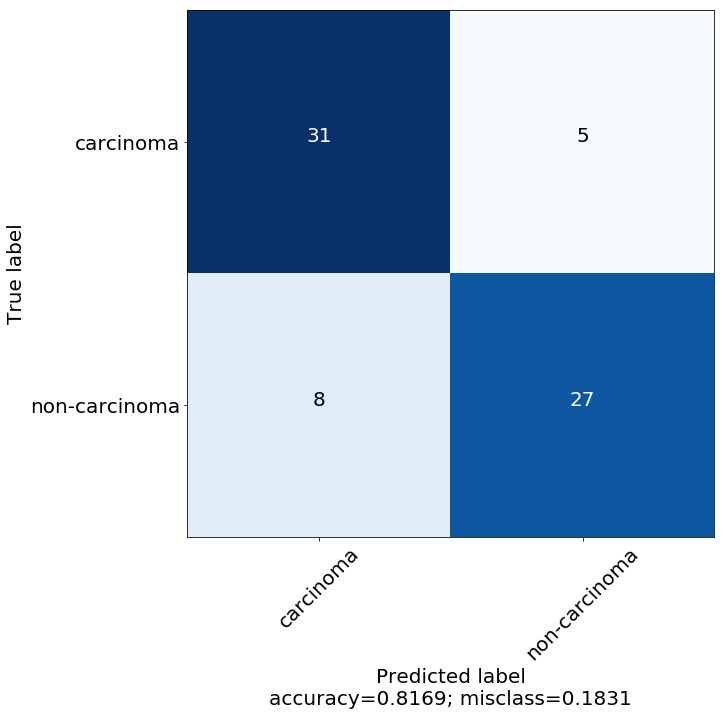

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[31  5]
 [ 8 27]]
               precision    recall  f1-score   support

    carcinoma       0.79      0.86      0.83        36
non-carcinoma       0.84      0.77      0.81        35

  avg / total       0.82      0.82      0.82        71



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  79.48717948717949
Specificity :  84.375


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8193108974358975


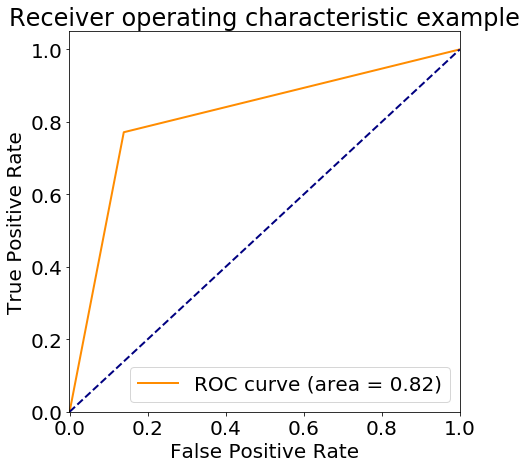

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 0us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

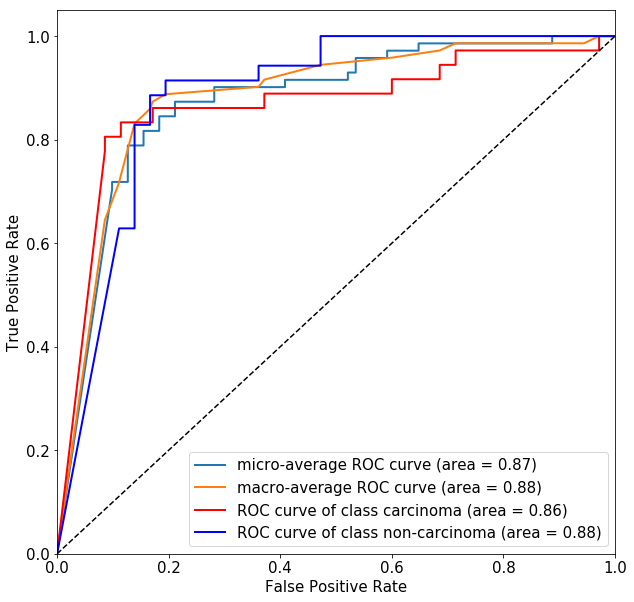

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8169014084507042
Precision: 0.84375
Recall: 0.7714285714285715
tp: 27
fp: 5
tn: 31
fn: 8


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8059701492537314


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8059701492537313


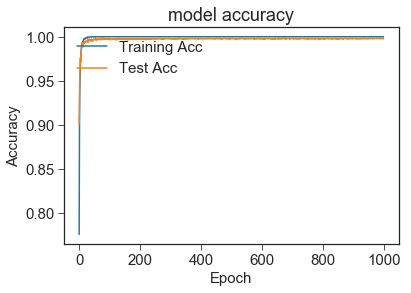

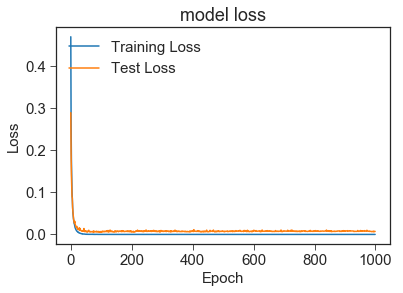

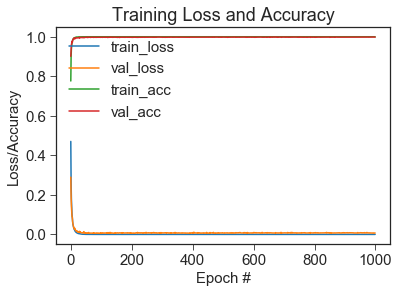

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")